# Overview

Mise à jour du code fourni par Aicha pour proposer de la prédiction LSTM de données

Les données d'entrée sont des données de consommation (data) d'un ensemble de téléphone autour d'une antenne.

## Premières fonctions

Parsing des données

Alignement sur un intervalle \[0,1\]

Algo LTSM

Prédiction

In [1]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
 
# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
 
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# scale train and test data to [0, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(0, 0.9))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]
 
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	print(X.shape)
	model = tf.keras.models.Sequential([
		#tf.keras.layers.Input(shape=(1,1), name='input'),
		tf.keras.layers.LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=False),
		#tf.keras.layers.Flatten(),
		tf.keras.layers.Dense(1,name='output')
	])
	model.compile(loss='mean_squared_error', optimizer='adam')
#	model.compile(optimizer='adam',
#                  loss='sparse_categorical_crossentropy',
#                  metrics=['accuracy'])
	model.summary()
	#for i in range(nb_epoch):
	#	model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
	#	model.reset_states()
	model.fit(X, y, epochs=nb_epoch, batch_size=batch_size, verbose=0, shuffle=False)
	return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]
 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """


INFO:tensorflow:Using local port 16252
INFO:tensorflow:Using local port 15800
INFO:tensorflow:Using local port 20424
INFO:tensorflow:Using local port 18126
INFO:tensorflow:Using local port 17547
INFO:tensorflow:Using local port 19113
INFO:tensorflow:Using local port 18853
INFO:tensorflow:Using local port 23975
INFO:tensorflow:Using local port 20704
INFO:tensorflow:Using local port 18631


## Evaluation

Fonction de détermination de l'erreur absolue en pourcentage

Combien de \% d'écart en moyenne entre la donnée prédite et la donnée mesurée

In [84]:
def mean_absolute_percentage_error(y_true, y_pred): 
     return ((numpy.fabs(y_true - y_pred)/y_true).mean())

## Importation des données

Colonnes importées : 2e, 3e et 8e colonnes

2e colonne : Temps
3e colonne : identifiant Antenne
7e colonne : Quantité de données

In [85]:
dataframe = read_csv('dataset3semaines.csv', usecols=[1,2,7], engine='python')

In [86]:
dataset = dataframe.values

In [87]:
dataset = dataset.astype('float32')
where_are_NaNs = numpy.isnan(dataset)
dataset[where_are_NaNs] = 0

## Sélection des données

Isolation d'une antenne (ID : 39)

Convertion du temps en heures

In [88]:
newdataset1 = []
newdataset2 = []

for i in range(len(dataset)):
    if dataset[i,1]==39:
        a = dataset[i, 2]
        b = (dataset[i, 0]-1383260400000)/3600000
        newdataset1.append(a)
        newdataset2.append(b)


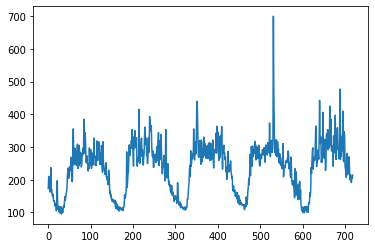

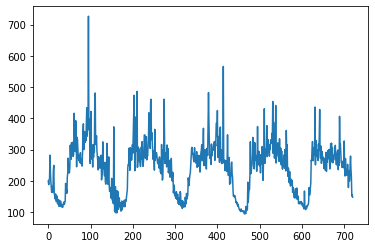

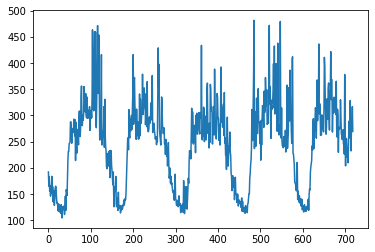

In [89]:
raw_values = numpy.asarray(newdataset1)
l=len(raw_values)
pyplot.plot(raw_values[:int(l/3)])
pyplot.show()
pyplot.plot(raw_values[int(l/3):-int(l/3)])
pyplot.show()
pyplot.plot(raw_values[-int(l/3):])
pyplot.show()

## Découpage du jeu de données

Définition d'un jeu d'entrainement et d'un jeu de test

Mise à l'échelle des données sur l'intervalle \[0,1\]

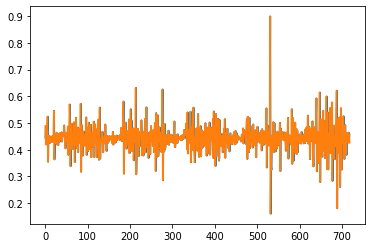

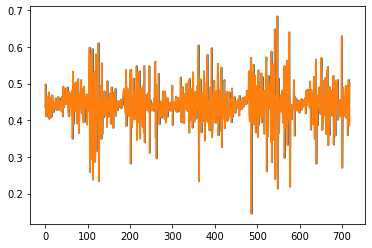

In [90]:
diff_values = difference(raw_values, 1)
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
 
# split data into train and test-sets
train, test = supervised_values[0:-int(l/3)], supervised_values[-int(l/3):]
 
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

pyplot.plot(train_scaled[:int(l/3)])
pyplot.show()
pyplot.plot(test_scaled[:int(l/3)])
pyplot.show()

## Entrainement

In [123]:
lstm_model = fit_lstm(train_scaled, 1, 1, 2)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

(1439, 1, 1)
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (1, 2)                    32        
_________________________________________________________________
output (Dense)               (1, 1)                    3         
Total params: 35
Trainable params: 35
Non-trainable params: 0
_________________________________________________________________


array([[0.4426661 ],
       [0.44755855],
       [0.43975955],
       ...,
       [0.43929434],
       [0.43312746],
       [0.44310614]], dtype=float32)

## Prédiction

Prédiction de la donnée et établissement d'un jeu de données prédite.

In [124]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	expected = raw_values[len(train) + i + 1]

	predictions.append(yhat)

for i in range(len(test_scaled)):
	print('hour=%d, Predicted=%f, Expected=%f' % ((i+1)/6, predictions[i], raw_values[len(train) + i + 1]))

hour=0, Predicted=145.982452, Expected=191.956055
hour=0, Predicted=195.758995, Expected=164.897003
hour=0, Predicted=160.756492, Expected=182.858307
hour=0, Predicted=183.948483, Expected=155.276047
hour=0, Predicted=151.070393, Expected=165.862061
hour=1, Predicted=166.146431, Expected=145.821472
hour=1, Predicted=142.545470, Expected=163.629761
hour=1, Predicted=164.703401, Expected=157.103607
hour=1, Predicted=155.441265, Expected=183.635971
hour=1, Predicted=185.637409, Expected=150.563354
hour=1, Predicted=145.667791, Expected=164.106354
hour=2, Predicted=164.716217, Expected=134.988403
hour=2, Predicted=130.590859, Expected=141.608185
hour=2, Predicted=141.450948, Expected=156.797821
hour=2, Predicted=157.587527, Expected=128.033493
hour=2, Predicted=123.680239, Expected=139.992706
hour=2, Predicted=140.428604, Expected=159.881165
hour=3, Predicted=161.178596, Expected=164.712021
hour=3, Predicted=164.353722, Expected=162.614120
hour=3, Predicted=161.465869, Expected=144.544479


## Illustration des performances de l'algorithme

Détermination du pourcentage d'erreur moyen

Tracé des courbes

Premières courbes : Ensemble des données

Deuxièmes courbes : Zoom sur les données

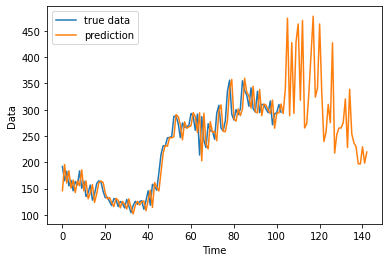

Raw Mean:  242.07082
Prediction Mean :  245.1457810648884


In [125]:
# report performance
#rmse = mean_absolute_percentage_error(raw_values[-int(l/3):], predictions) * 100
#print('Test MAPE: %.3f pourcents de précision en moyenne' % rmse)
# line plot of observed vs predicted
#pyplot.plot(raw_values[-int(l/3):], label="true data")
#pyplot.plot(predictions, label="prediction")
#pyplot.ylabel('Data')
#pyplot.xlabel('Time')
#pyplot.legend(loc='upper left')
#pyplot.show()
pyplot.plot(raw_values[-int(l/3):-int(4*l/14)], label="true data")
pyplot.plot(predictions[:int(len(predictions)/5)], label="prediction")
pyplot.ylabel('Data')
pyplot.xlabel('Time')
pyplot.legend(loc='upper left')
pyplot.show()
pyplot.show()
print("Raw Mean: " ,numpy.mean(raw_values))
print("Prediction Mean : " ,numpy.mean(predictions))

## Compte des données transmises dans le cas Machine Learning

Méthodologie : 
-    Comparaison de la donnée avec la donnée réelle
-    Si la donnée est différente de plus de 10\%, on réalise une transmission
-    Sinon, On ne fait rien

In [95]:
count = 1
for i in range(len(test_scaled)):
    if ((numpy.fabs(predictions[i] - raw_values[len(train) + i + 1])/raw_values[len(train) + i + 1])>0.1) :
        count+=1
print('Count : %d, Total : %d, Proportion : %.1f' % (count, len(test_scaled), count/len(test_scaled)*100))

Count : 378, Total : 719, Proportion : 52.6


## Compte des données transmises dans un cas sans Machine Learning

Méthodologie : 
-    Comparaison de la donnée précédemment transmise avec la donnée réelle
-    Si la donnée réelle est différente de plus de 10\%, on réalise une transmission
-    Sinon, On ne fait rien

In [14]:
count = 1
previously_transmitted = raw_values[len(train) + 1]
for i in range(1, len(test_scaled)):
    if ((numpy.fabs(previously_transmitted - raw_values[len(train) + i + 1])/previously_transmitted)>0.1) :
        count+=1
        previously_transmitted = raw_values[len(train) + i + 1]
print('Count : %d, Total : %d, Proportion : %.1f' % (count, len(test_scaled), count/len(test_scaled)*100))

Count : 342, Total : 719, Proportion : 47.6


## Compte des données transmises dans le cas Machine Learning

Méthodologie :
-    Comparaison de la donnée alignée avec la donnée réelle
-    Si la donnée est différente de plus de 24 (seuil arbitraire fixé à 10\% de la moyenne des données), on réalise une transmission
-    Sinon, On ne fait rien

In [15]:
count = 0
#print('Transmitting : %f, Measured : %f' % (predictions_align[0], raw_values[len(train) + 1]))
for i in range(len(test_scaled)):
    if (numpy.fabs(predictions[i] - raw_values[len(train) + i + 1])>24) :
        count+=1
        #print ('%f', (numpy.fabs(predictions_align[i] - raw_values[len(train) + i + 1])/raw_values[len(train) + i + 1]))
        #print('Transmission : %d, Transmitting : %f, Measured : %f' % (count, predictions_align[i], raw_values[len(train)+ i + 1]))
print('Count : %d, Total : %d, Proportion : %.1f' % (count, len(test_scaled), count/len(test_scaled)*100))

Count : 335, Total : 719, Proportion : 46.6


## Compte des données transmises dans un cas sans Machine Learning

Méthodologie : 
-    Comparaison de la donnée précédemment transmise avec la donnée réelle
-    Si la donnée est différente de plus de 24 (seuil arbitraire fixé à 10\% de la moyenne des données), on réalise une transmission
-    Sinon, On ne fait rien

In [16]:
count = 1
previously_transmitted = raw_values[len(train) + 1]
#print('Transmitting : %f, Measured : %f' % (predictions_align[0], raw_values[len(train) + 1]))
for i in range(1, len(test_scaled)):
    if (numpy.fabs(raw_values[len(train) + i] - raw_values[len(train) + i + 1])>24) :
        count+=1
        previously_transmitted = raw_values[len(train) + i + 1]
        #print ('%f', (numpy.fabs(raw_values[len(train) + i] - raw_values[len(train) + i + 1])/raw_values[len(train) + i]))
        #print('Transmission : %d, Old : %f, New : %f, Threshold : %f ' % (count, raw_values[len(train) + i], raw_values[len(train)+ i + 1], 40))
print('Count : %d, Total : %d, Proportion : %.1f' % (count, len(test_scaled), count/len(test_scaled)*100))

Count : 313, Total : 719, Proportion : 43.5


## Courbe illustrant les transmissions dans le cas Machine Learning

Méthodologie : 
-    Calcul de l'écart en \% entre donnée réelle et donnée prédite

Count : 312, Total : 719, Percentage : 43.4


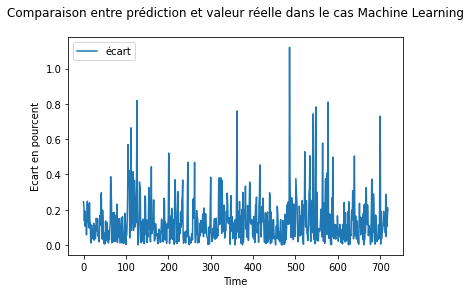

In [17]:
count = 1
variation_ml = list()
#print('Transmitting : %f, Measured : %f' % (predictions_align[0], raw_values[len(train) + 1]))
for i in range(len(test_scaled)):
    variation_ml.append(numpy.fabs(predictions[i] - raw_values[len(train) + i + 1])/raw_values[len(train) + i + 1])
    if (variation_ml[i]>0.12) :
        count+=1
#        print ('%f' % variation_ml[i])
#        print('Transmission : %d, Transmitting : %f, Measured : %f' % (count, predictions_align[i], raw_values[len(train)+ i + 1]))
#print('Count : %d, Total : %d, Proportion : %f' % (count, len(test_scaled), count/len(test_scaled)*100))

print('Count : %d, Total : %d, Percentage : %.1f' % (count, len(test_scaled), count / len(test_scaled)*100))
pyplot.plot(variation_ml, label="écart")
pyplot.ylabel('Ecart en pourcent')
pyplot.xlabel('Time')
pyplot.legend(loc='upper left')
pyplot.title('Comparaison entre prédiction et valeur réelle dans le cas Machine Learning\n')
pyplot.show()

## Courbe illustrant les transmissions dans le cas sans Machine Learning

Méthodologie : 
-    Calcul de l'écart en \% entre donnée réelle et donnée précédemment transmise

Count : 285, Total : 719, Percentage : 39.6


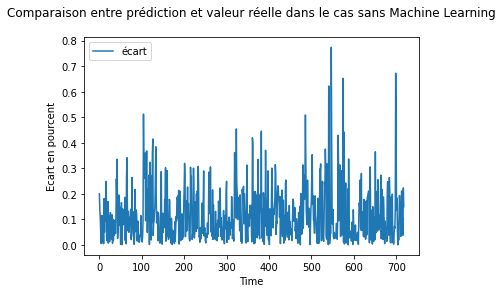

In [18]:
count = 1
variation_no_ml = list()
variation_no_ml.append(0.2)#raw_values[len(train) + 1])
previously_transmitted = raw_values[len(train) + 1]
#print('Transmitting : %f, Measured : %f' % (predictions[0], raw_values[len(train) + 1]))
for i in range(1, len(test_scaled)):
    variation_no_ml.append(numpy.fabs(previously_transmitted - raw_values[len(train) + i + 1])/previously_transmitted)
    if (variation_no_ml[i]>0.12) :
        count+=1
        previously_transmitted = raw_values[len(train) + i + 1]
#        print ('%f' % variation_no_ml[i])
#        print('Transmission : %d, Old : %f, New : %f, Threshold : %f ' % (count, raw_values[len(train) + i], raw_values[len(train)+ i + 1], raw_values[len(train) + i]*0.2))

#print('Count : %d, Total : %d, Proportion : %f' % (count, len(test_scaled), count/len(test_scaled)*100))

print('Count : %d, Total : %d, Percentage : %.1f' % (count, len(test_scaled), count / len(test_scaled)*100))
pyplot.plot(variation_no_ml, label="écart")
pyplot.ylabel('Ecart en pourcent')
pyplot.xlabel('Time')
pyplot.legend(loc='upper left')
pyplot.title('Comparaison entre prédiction et valeur réelle dans le cas sans Machine Learning\n')
pyplot.show()

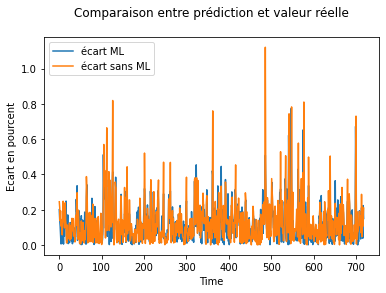

In [19]:
pyplot.plot(variation_no_ml, label="écart ML")
pyplot.plot(variation_ml, label="écart sans ML")
pyplot.ylabel('Ecart en pourcent')
pyplot.xlabel('Time')
pyplot.legend(loc='upper left')
pyplot.title('Comparaison entre prédiction et valeur réelle\n')
pyplot.show()

## Même courbes que ci-dessus mais regroupées et zoomées 

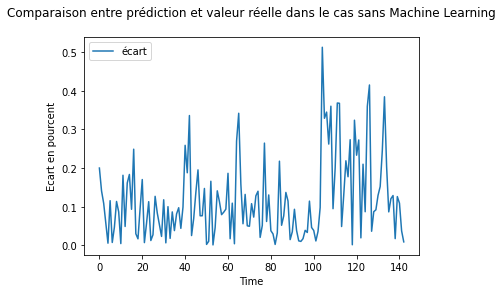

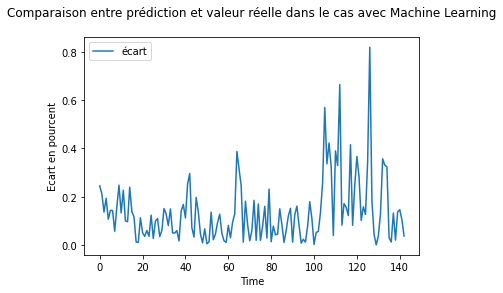

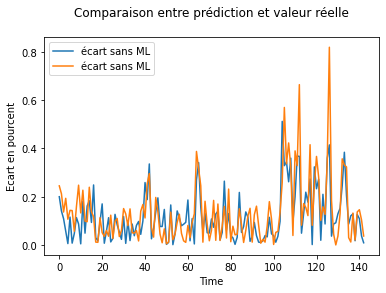

In [20]:
pyplot.plot(variation_no_ml[:int(len(variation_no_ml)/5)], label="écart")
pyplot.ylabel('Ecart en pourcent')
pyplot.xlabel('Time')
pyplot.legend(loc='upper left')
pyplot.title('Comparaison entre prédiction et valeur réelle dans le cas sans Machine Learning\n')
pyplot.show()
pyplot.plot(variation_ml[:int(len(variation_ml)/5)], label="écart")
pyplot.ylabel('Ecart en pourcent')
pyplot.xlabel('Time')
pyplot.legend(loc='upper left')
pyplot.title('Comparaison entre prédiction et valeur réelle dans le cas avec Machine Learning\n')
pyplot.show()
pyplot.plot(variation_no_ml[:int(len(variation_no_ml)/5)], label="écart sans ML")
pyplot.plot(variation_ml[:int(len(variation_ml)/5)], label="écart sans ML")
pyplot.ylabel('Ecart en pourcent')
pyplot.xlabel('Time')
pyplot.legend(loc='upper left')
pyplot.title('Comparaison entre prédiction et valeur réelle\n')
pyplot.show()


## Et en terme de transmissions, ça donne quoi

In [21]:
transmissions_compare=list()
for i in range(len(variation_ml)):
    if (variation_ml[i]<0.1 and variation_no_ml[i]<0.1):
        transmissions_compare.append(0)
    if (variation_ml[i]>0.1 and variation_no_ml[i]<0.1):
        transmissions_compare.append(1)
    if (variation_ml[i]<0.1 and variation_no_ml[i]>0.1):
        transmissions_compare.append(0)
    if (variation_ml[i]>0.1 and variation_no_ml[i]>0.1):
        transmissions_compare.append(1)

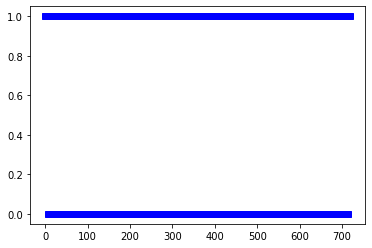

In [22]:
pyplot.plot(transmissions_compare, 'bs')
pyplot.show()

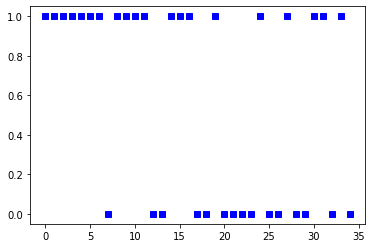

In [23]:
pyplot.plot(transmissions_compare[:int(len(transmissions_compare)/20)], 'bs')
pyplot.show()

In [24]:
transmissions_compare=list()
for i in range(len(variation_ml)):
    if (variation_ml[i]<0.1 and variation_no_ml[i]<0.1):
        transmissions_compare.append(-2)
    if (variation_ml[i]>0.1 and variation_no_ml[i]<0.1):
        transmissions_compare.append(-1)
    if (variation_ml[i]<0.1 and variation_no_ml[i]>0.1):
        transmissions_compare.append(2)
    if (variation_ml[i]>0.1 and variation_no_ml[i]>0.1):
        transmissions_compare.append(1)

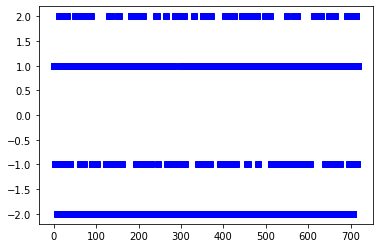

In [25]:
pyplot.plot(transmissions_compare, 'bs')
pyplot.show()

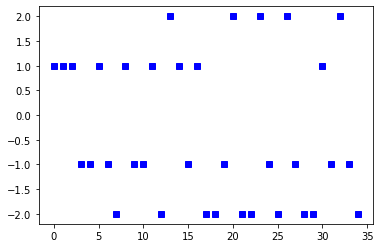

In [26]:
pyplot.plot(transmissions_compare[:int(len(transmissions_compare)/20)], 'bs')
pyplot.show()

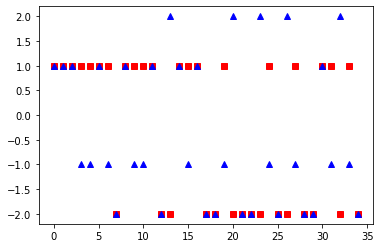

In [27]:
transmissions_compare1=list()
transmissions_compare2=list()
for i in range(len(variation_ml)):
    if (variation_ml[i]<0.1 and variation_no_ml[i]<0.1):
        transmissions_compare1.append(-2)
        transmissions_compare2.append(-2)
    if (variation_ml[i]>0.1 and variation_no_ml[i]<0.1):
        transmissions_compare1.append(1)
        transmissions_compare2.append(-1)
    if (variation_ml[i]<0.1 and variation_no_ml[i]>0.1):
        transmissions_compare1.append(-2)
        transmissions_compare2.append(2)
    if (variation_ml[i]>0.1 and variation_no_ml[i]>0.1):
        transmissions_compare1.append(1)
        transmissions_compare2.append(1)
        
pyplot.plot(transmissions_compare1[:int(len(transmissions_compare1)/20)], 'rs')
pyplot.plot(transmissions_compare2[:int(len(transmissions_compare2)/20)], 'b^')
pyplot.show()

## Fin

In [117]:
# walk-forward validation on the test data
train=supervised_values[0:-int(l/3)]
predictions = list()
y0=0
#for i in range(len(test_scaled)):
# make one-step forecast
X, y = test_scaled[32, 0:-1], test_scaled[32, -1]
print(test_scaled[31])
print(test_scaled[32])
print('X : %f' %X)
print('y : %f' %y)
yhat = forecast_lstm(lstm_model, 1, X)
print('yhat : %f' % yhat)
# invert scaling
yhat = invert_scale(scaler, X, yhat)
y = invert_scale(scaler, X, y)
print('y : %f' % y)
print('yhat : %f' % yhat)

# invert differencing
yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-32)
print(yhat)
y = inverse_difference(raw_values, y, len(test_scaled)+1-32)
print(y)

# store forecast
print(raw_values[len(train) + 32 + 1])
#if i==0:
#y0=yhat
#expected0=expected
#predictions.append(yhat)

#for i in range(len(test_scaled)):
#print('hour=%d, Predicted=%f, Expected=%f' % ((i+1)/6, predictions[i], raw_values[len(train) + i + 1]))

[0.46377603 0.42801968]
[0.42801968 0.4286432 ]
X : 0.428020
y : 0.428643
yhat : 0.437467
y : -12.382889
yhat : -5.161694
111.43156038295841
104.21036529541016
104.210365


In [29]:
# Scaling inversion testing
# From : https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#
# X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0)) 
# X_std is X with all X between 0 and 1
# X_scaled = X_std * (max - min) + min
# Above is a simple scaling function to fit between min and max (0 and 1 by default here changed to 0 and 0.9)


# So : 

# X = X_std * (X.max(axis=0) - X.min(axis=0)) + X.min(axis=0)
# Where X_std = (X_scaled - min)/(max-min)

# With max = 0.9, min = 0, X.max(axis=0)=373.3527832 , X.min(axis=0)=-363.16381836 (extracted from data)
print(scaler.data_max_)
print(scaler.data_min_)

#Testing Formula below :
 
#VALUE = X_scaled / 0.9 * (373.3527832 + 363.16381836) - 363.16381836
#From above : -12.382889 = f(X = 0.428020, y = 0.428643)
#Testing :
(0.4286432) / 0.9 * (373.3527832 + 363.16381836) - 363.16381836
# Result : -12.382892864662892

# Testing with yhat f(0.445836)=1.686725
(0.445836) / 0.9 * (373.3527832 + 363.16381836) - 363.16381836
# Result : 1.686865610115774

[373.3527832 373.3527832]
[-363.16381836 -363.16381836]


1.686865610115774

In [30]:
# Testing differenciation function

# Y_final = Y_delta_calculated_above + Previous value
# Here : Y_33 = y_delta_calculated_32_33 + Y_32

print ('y_33_calculated = %f ' % (-12.382892864662892 + raw_values[len(train_scaled)+32]))
print ('y_33_real = %f ' % raw_values[len(train_scaled)+33])
print ('y_33_predicted = %f ' % (1.686865610115774 + raw_values[len(train_scaled)+32]))



y_33_calculated = 104.210361 
y_33_real = 104.210365 
y_33_predicted = 118.280120 


In [31]:
raw_values

array([173.0813 , 210.26813, 190.14723, ..., 268.86017, 316.82578,
       269.3911 ], dtype=float32)

In [32]:
predicted_data_plot = list()
true_data_plot = list()
for i in range(len(test_scaled)):
    if (numpy.fabs(predictions[i] - raw_values[len(train) + i + 1])/raw_values[len(train) + i + 1]<=0.12) :
        predicted_data_plot.append(raw_values[len(train) + i + 1])
        true_data_plot.append(numpy.nan)
    else :
        predicted_data_plot.append(numpy.nan)
        true_data_plot.append(predictions[i])

IndexError: list index out of range

In [ ]:
#pyplot.plot(raw_values[-int(l/3):-int(4*l/15)], label="true data")
#pyplot.plot(predictions[:int(len(predictions)/5)], label="prediction")

pyplot.plot(true_data_plot[:int(len(true_data_plot)/5)], label="True Data")
pyplot.plot(predicted_data_plot[:int(len(predicted_data_plot)/5)], label="Predicted Data")

pyplot.ylabel('Data')
pyplot.xlabel('Time')
pyplot.legend(loc='upper left')
pyplot.show()
pyplot.show()
print("Raw Mean: " ,numpy.mean(raw_values))
print("Prediction Mean : " ,numpy.mean(predictions))

In [ ]:
    variation_ml.append()
    if (variation_ml[i]>0.12) :
        count+=1

## Addendum conversion en modèle TFLite

In [ ]:
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

In [ ]:
run_model = tf.function(lambda x: lstm_model(x))
# This is important, let's fix the input size.
BATCH_SIZE = 1
STEPS = 1
INPUT_SIZE = 1
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec([BATCH_SIZE, STEPS, INPUT_SIZE], lstm_model.inputs[0].dtype))

# model directory.
MODEL_DIR = "keras_lstm"
lstm_model.save(MODEL_DIR, save_format="tf", signatures=concrete_func)

converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)
print('Model converted successfully!')

In [40]:
# Step 3: Convert the Keras model to TensorFlow Lite model.
#sess = tf.keras.backend.get_session()

!mkdir -p saved_model
lstm_model.save('saved_model/my_model') 

#converter = tf.lite.TFLiteConverter.from_keras_model(lstm_model)
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model/my_model')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,tf.lite.OpsSet.SELECT_TF_OPS]
tflite_model = converter.convert()


#tflite_model = converter.convert()



open("converted_model.tflite", "wb").write(tflite_model)
print('Model converted successfully!')
## xxd -i converted_model.tflite > converted_model.cc

AttributeError: module 'tensorflow.python.keras.api._v2.keras.backend' has no attribute 'get_session'

In [ ]:
tf.saved_model

In [ ]:
# report performance
rmse = sqrt(mean_squared_error(raw_values[-int(l/3):], predictions_align))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-int(l/3):])
pyplot.plot(predictions  + numpy.mean(raw_values) - numpy.mean(predictions))
pyplot.show()
pyplot.plot(raw_values[-int(l/3):-int(4*l/15)])
pyplot.plot(predictions[:int(len(predictions)/5)])
pyplot.show()
print("Raw : " ,numpy.mean(raw_values))
print("Prediction : " ,numpy.mean(predictions))

In [ ]:
# walk-forward validation on the test data
predictions = list()
#predictions_align = list()
y0=0
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	expected = raw_values[len(train) + i + 1]
	if i==0:
		y0=yhat
		expected0=expected
	predictions.append(yhat)#+ expected0-y0)

for i in range(len(test_scaled)):
#	predictions_align.append(predictions[i]+ numpy.mean(raw_values) - numpy.mean(predictions))
	print('hour=%d, Predicted=%f, Expected=%f' % ((i+1)/6, predictions[i], raw_values[len(train) + i + 1]))

    
#for i in range(len(test_scaled)):
#	predictions_align.append(predictions[i]+ numpy.mean(raw_values) - numpy.mean(predictions))
#	print('hour=%d, Predicted=%f, Predicted After Alignment=%f, Expected=%f' % ((i+1)/6, predictions[i], predictions_align[i], raw_values[len(train) + i + 1]))
 
#2:37


In [126]:
lstm_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (1, 2)                    32        
_________________________________________________________________
output (Dense)               (1, 1)                    3         
Total params: 35
Trainable params: 35
Non-trainable params: 0
_________________________________________________________________


In [127]:
lstm_model

In [128]:
lstm_model.layers

In [129]:
print("LSTM : \n")
print(lstm_model.layers[0].get_weights())
print("\nDense : \n")
print(lstm_model.layers[1].get_weights())

LSTM : 

[array([[ 0.21559802,  1.0036521 ,  0.7399131 , -0.6464349 , -0.35157195,
         0.9950461 ,  0.04572607, -0.3103752 ]], dtype=float32), array([[ 0.1178571 ,  0.07494306,  0.36561152,  0.06129263,  0.1761487 ,
        -0.12523508, -0.23544899, -0.860765  ],
       [-0.35892805,  0.27519187,  0.32636738,  0.5828191 , -0.5092863 ,
        -0.04624452,  0.2952817 , -0.02332199]], dtype=float32), array([-0.04870209,  0.31565154,  1.        ,  1.        ,  0.22130239,
        0.29005966, -0.04910143,  0.2940091 ], dtype=float32)]

Dense : 

[array([[0.88074213],
       [0.87417465]], dtype=float32), array([0.2390506], dtype=float32)]


In [130]:
print(lstm_model.layers[0].get_weights()[0])


[[ 0.21559802  1.0036521   0.7399131  -0.6464349  -0.35157195  0.9950461
   0.04572607 -0.3103752 ]]


In [134]:
print(test_scaled[0:9])

[[0.43552217 0.49788915]
 [0.49788915 0.4107094 ]
 [0.4107094  0.46572285]
 [0.46572285 0.41007005]
 [0.41007005 0.45671048]
 [0.45671048 0.41928574]
 [0.41928574 0.46553587]
 [0.46553587 0.43579995]
 [0.43579995 0.47619641]]


In [135]:
raw_values[-int(l/3):]

array([191.95605 , 164.897   , 182.8583  , 155.27605 , 165.86206 ,
       145.82147 , 163.62976 , 157.1036  , 183.63597 , 150.56335 ,
       164.10635 , 134.9884  , 141.60818 , 156.79782 , 128.0335  ,
       139.9927  , 159.88116 , 164.71202 , 162.61412 , 144.54448 ,
       132.65446 , 133.62535 , 125.02608 , 117.649826, 130.96637 ,
       128.98077 , 115.817986, 125.533104, 121.99191 , 113.118286,
       129.4864  , 116.593254, 104.210365, 117.9344  , 125.85579 ,
       120.260826, 125.24759 , 127.10816 , 110.70083 , 127.304375,
       145.7845  , 118.403046, 158.15271 , 154.10442 , 147.138   ,
       179.78323 , 214.88875 , 231.35289 , 231.36711 , 246.52998 ,
       247.18672 , 249.18405 , 287.4233  , 287.81732 , 274.1872  ,
       246.8557  , 274.84616 , 266.50366 , 268.068   , 270.0303  ,
       292.871   , 287.7819  , 260.86005 , 291.5957  , 213.83049 ,
       286.8689  , 241.48103 , 227.94814 , 273.33765 , 259.46674 ,
       259.78473 , 243.82672 , 293.36374 , 308.372   , 265.169

In [118]:
(0.449882 - 0.17336495) / (-1.2636627)  # YT-1

-0.2188218818202041

In [119]:
(0.42801968 - 0.17336495) / (-1.2636627) # X

-0.20152112585106774

In [120]:
(0.4286432 - 0.17336495) / (-1.2636627) # YT

-0.2020145486608096

In [ ]:
lstm_model.get_variable_value(lstm_model.get_variable_names()[3])   